In [1]:
%matplotlib inline
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import os
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import xgboost as xgb

from IPython.display import display
pd.set_option('display.max_columns', None)


filepath_functions = os.path.join(os.path.abspath('..'), 'Python files')
sys.path.insert(1, filepath_functions)

from  import *

In [97]:
filepath_X_train = os.path.join(os.path.abspath('..'), 'Files', 'AMF_train_X.csv')
filepath_y_train = os.path.join(os.path.abspath('..'), 'Files', 'AMF_train_Y.csv')
filepath_X_test = os.path.join(os.path.abspath('..'), 'Files', 'AMF_test_X.csv')
filepath_best_sub = os.path.join(os.path.abspath('..'), 'Files', 'Best_sub.csv')
filepath_sub_Hugo = os.path.join(os.path.abspath('..'), 'Files', 'claqué_au_sol5.csv')


X_train_original = pd.read_csv(filepath_X_train)
y_train_original = pd.read_csv(filepath_y_train)
X_test_original = pd.read_csv(filepath_X_test)
Best_sub = pd.read_csv(filepath_best_sub, sep=";")
sub_Hugo = pd.read_csv(filepath_sub_Hugo)

X_train_original.set_index("Index", drop=True, inplace=True)
X_test_original.set_index("Index", drop=True, inplace=True)
Best_sub.set_index("Trader", drop=True, inplace=True)
Best_sub.rename(columns={"type": "pred_Aya"}, inplace=True)
sub_Hugo.set_index("Trader", drop=True, inplace=True)
sub_Hugo.rename(columns={"type": "pred_Hugo"}, inplace=True)

In [8]:
X_anonymized, y_train_reshaped, X_pred, X_non_anonymized =  cleaning_function(X_train_original, y_train_original, X_test_original)

X_grouped_by = X_non_anonymized.groupby("Trader").mean()

In [13]:
X_grouped_by_type = pd.merge(X_grouped_by, y_train_original, how='left', on="Trader")

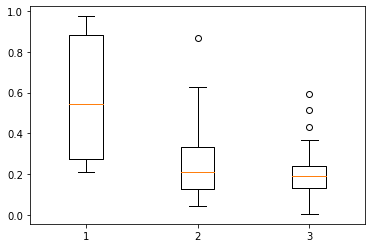

In [15]:
# X_grouped_by_type
x1 = X_grouped_by_type[X_grouped_by_type["type"] == "HFT"]["OTR_new"]
x2 = X_grouped_by_type[X_grouped_by_type["type"] == "MIX"]["OTR_new"]
x3 = X_grouped_by_type[X_grouped_by_type["type"] == "NON HFT"]["OTR_new"]
plt.boxplot ([x1, x2, x3]);

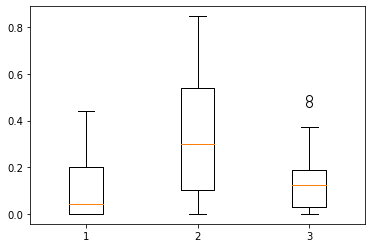

In [16]:
x1 = X_grouped_by_type[X_grouped_by_type["type"] == "HFT"]["OMR_new"]
x2 = X_grouped_by_type[X_grouped_by_type["type"] == "MIX"]["OMR_new"]
x3 = X_grouped_by_type[X_grouped_by_type["type"] == "NON HFT"]["OMR_new"]
plt.boxplot ([x1, x2, x3]);

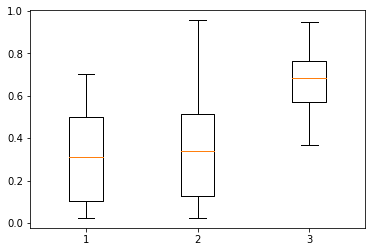

In [17]:
x1 = X_grouped_by_type[X_grouped_by_type["type"] == "HFT"]["OCR_new"]
x2 = X_grouped_by_type[X_grouped_by_type["type"] == "MIX"]["OCR_new"]
x3 = X_grouped_by_type[X_grouped_by_type["type"] == "NON HFT"]["OCR_new"]
plt.boxplot ([x1, x2, x3]);

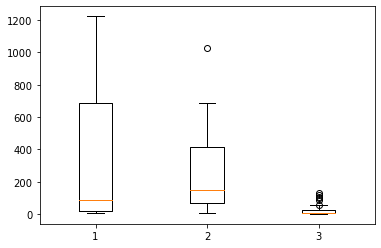

In [18]:
x1 = X_grouped_by_type[X_grouped_by_type["type"] == "HFT"]["NbSecondWithAtLeatOneTrade"]
x2 = X_grouped_by_type[X_grouped_by_type["type"] == "MIX"]["NbSecondWithAtLeatOneTrade"]
x3 = X_grouped_by_type[X_grouped_by_type["type"] == "NON HFT"]["NbSecondWithAtLeatOneTrade"]
plt.boxplot ([x1, x2, x3]);

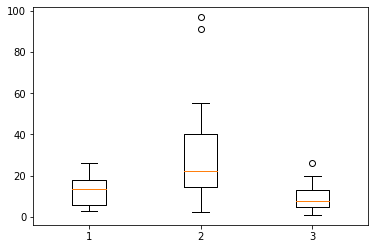

In [19]:
x1 = X_grouped_by_type[X_grouped_by_type["type"] == "HFT"]["MaxNbTradesBySecond"]
x2 = X_grouped_by_type[X_grouped_by_type["type"] == "MIX"]["MaxNbTradesBySecond"]
x3 = X_grouped_by_type[X_grouped_by_type["type"] == "NON HFT"]["MaxNbTradesBySecond"]
plt.boxplot ([x1, x2, x3]);

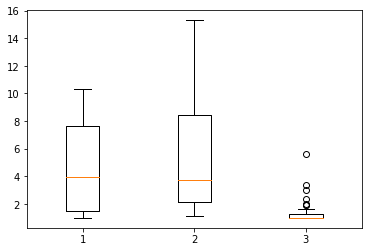

In [20]:
x1 = X_grouped_by_type[X_grouped_by_type["type"] == "HFT"]["NbTradeVenueMic"]
x2 = X_grouped_by_type[X_grouped_by_type["type"] == "MIX"]["NbTradeVenueMic"]
x3 = X_grouped_by_type[X_grouped_by_type["type"] == "NON HFT"]["NbTradeVenueMic"]
plt.boxplot ([x1, x2, x3]);

In [23]:
y_model = X_grouped_by_type["type"]
X_model = X_grouped_by_type.drop(columns=["Trader", "Day", "Share", "type"]).dropna(axis="columns")

In [25]:
rf_model = RandomForestClassifier()
X_train, X_valid, y_train, y_valid = train_test_split(X_model, y_model, train_size=0.7, random_state=15)
y_pred_rf = rf_model.fit(X_train, y_train).predict(X_valid)
print('RF accuracy %s' % f1_score(y_pred_rf, y_valid, average='micro'))

RF accuracy 0.8846153846153846


In [30]:
model_lgbm = LGBMClassifier(boosting_type='dart', n_estimators=2000, learning_rate=0.05, max_depth=10,
                       num_leaves=16, subsample=0.9, colsample_bytree=0.9, subsample_freq=1,
                       uniform_drop=True)
preds_lgbm = model_lgbm.fit(X_train, y_train).predict(X_valid)
print('LightGBM accuracy %s' % f1_score(preds_lgbm, y_valid, average='micro'))

LightGBM accuracy 0.6153846153846154


In [27]:
model_xgb = xgb.XGBClassifier()
preds_xgb = model_xgb.fit(X_train, y_train).predict(X_valid)
print('XGB accuracy %s' % f1_score(preds_xgb, y_valid, average='micro'))

C:\Users\Adrien CATUSSE\anaconda3\envs\V-env ML2 Project\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[22:11:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB accuracy 0.7692307692307693


In [61]:
X_pred_to_use = X_pred.groupby("Trader").mean()

X_pred_to_use[[
    'min_dt_TV1', 'mean_dt_TV1', 'med_dt_TV1'
    ]] = X_pred_to_use[[
        'min_dt_TV1', 'mean_dt_TV1', 'med_dt_TV1'
        ]].fillna(value=0)
X_pred_to_use_2 = X_pred_to_use.drop(columns=["Day", "Share"]).dropna(axis="columns")
X_pred_to_use_2

,min_time_two_events,mean_time_two_events,max_time_two_events,mean_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,NbSecondWithAtLeatOneTrade,Total OR,OTR_new,OMR_new,OCR_new
Trader,,,,,,,,,,,,,,,
Adelaide,2.026000e-04,40.031248,322.540292,229.448817,1.000000,9.100000,5.185417,0.001200,1155.431586,0.232800,4.900000,28.834594,0.094301,0.063158,0.842542
Alana,2.138264e+02,6642.866960,34200.728943,18023.320178,1.000000,8.783784,1.987257,1973.927742,3960.774477,2642.501774,20.540541,62.303323,0.120142,0.171532,0.708326
Alcmene,3.878636e+03,10675.070452,17622.613377,16525.469547,1.562500,6.812500,2.355333,1434.263596,1787.786123,1435.627098,45.812500,11.523090,0.160829,0.000000,0.839171
Alice,2.484502e-07,107.664516,22065.246332,109.946313,6.995231,18.271340,2.608895,26.819070,139.290577,44.051277,475.942299,57.605723,0.951353,0.000000,0.048647
Alices Sister,1.569779e+02,1762.724624,9461.397849,5651.365232,1.142077,6.540984,2.885145,1334.873494,3876.150827,2054.373494,7.584699,24.352728,0.149028,0.261973,0.588999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Monstro,5.250000e-06,18.184575,227.489119,174.522687,10.250000,12.500000,2.322480,0.016250,31.021700,0.021750,78.750000,53.933437,0.072323,0.000000,0.927677
Morgana,3.119828e+00,3687.206446,19519.880445,850.959785,7.304813,13.577540,1.993032,199.327107,520.098218,296.025436,143.919786,71.002550,0.101161,0.217697,0.681142
The Doorknob,7.809037e-01,16.044565,369.374195,29.354461,1.835526,10.111842,2.652548,205.440955,944.584735,213.626694,44.664474,139.620309,0.367265,0.304261,0.328474


In [62]:
X_pred_to_use_2

,min_time_two_events,mean_time_two_events,max_time_two_events,mean_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,NbSecondWithAtLeatOneTrade,Total OR,OTR_new,OMR_new,OCR_new
Trader,,,,,,,,,,,,,,,
Adelaide,2.026000e-04,40.031248,322.540292,229.448817,1.000000,9.100000,5.185417,0.001200,1155.431586,0.232800,4.900000,28.834594,0.094301,0.063158,0.842542
Alana,2.138264e+02,6642.866960,34200.728943,18023.320178,1.000000,8.783784,1.987257,1973.927742,3960.774477,2642.501774,20.540541,62.303323,0.120142,0.171532,0.708326
Alcmene,3.878636e+03,10675.070452,17622.613377,16525.469547,1.562500,6.812500,2.355333,1434.263596,1787.786123,1435.627098,45.812500,11.523090,0.160829,0.000000,0.839171
Alice,2.484502e-07,107.664516,22065.246332,109.946313,6.995231,18.271340,2.608895,26.819070,139.290577,44.051277,475.942299,57.605723,0.951353,0.000000,0.048647
Alices Sister,1.569779e+02,1762.724624,9461.397849,5651.365232,1.142077,6.540984,2.885145,1334.873494,3876.150827,2054.373494,7.584699,24.352728,0.149028,0.261973,0.588999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Monstro,5.250000e-06,18.184575,227.489119,174.522687,10.250000,12.500000,2.322480,0.016250,31.021700,0.021750,78.750000,53.933437,0.072323,0.000000,0.927677
Morgana,3.119828e+00,3687.206446,19519.880445,850.959785,7.304813,13.577540,1.993032,199.327107,520.098218,296.025436,143.919786,71.002550,0.101161,0.217697,0.681142
The Doorknob,7.809037e-01,16.044565,369.374195,29.354461,1.835526,10.111842,2.652548,205.440955,944.584735,213.626694,44.664474,139.620309,0.367265,0.304261,0.328474


In [67]:
y_out = rf_model.fit(X_model, y_model).predict(X_pred_to_use_2)

In [65]:
X_pred_to_use_2.columns

Index(['min_time_two_events', 'mean_time_two_events', 'max_time_two_events',
       'mean_lifetime_cancel', 'NbTradeVenueMic', 'MaxNbTradesBySecond',
       'MeanNbTradesBySecond', 'min_dt_TV1', 'mean_dt_TV1', 'med_dt_TV1',
       'NbSecondWithAtLeatOneTrade', 'Total OR', 'OTR_new', 'OMR_new',
       'OCR_new'],
      dtype='object')

In [66]:
X_model.columns

Index(['min_time_two_events', 'mean_time_two_events', 'max_time_two_events',
       'mean_lifetime_cancel', 'NbTradeVenueMic', 'MaxNbTradesBySecond',
       'MeanNbTradesBySecond', 'min_dt_TV1', 'mean_dt_TV1', 'med_dt_TV1',
       'NbSecondWithAtLeatOneTrade', 'Total OR', 'OTR_new', 'OMR_new',
       'OCR_new'],
      dtype='object')

In [73]:
traders = X_pred_to_use_2.index
res = pd.DataFrame(traders)
res['pred'] = y_out
res.set_index("Trader", drop=True, inplace=True)
res

,pred
Trader,
Adelaide,NON HFT
Alana,NON HFT
Alcmene,NON HFT
Alice,HFT
Alices Sister,NON HFT
...,...
Monstro,NON HFT
Morgana,MIX
The Doorknob,HFT


In [98]:
merged = pd.merge(res, Best_sub, how="left", on="Trader")
merged = pd.merge(merged, sub_Hugo, how="left", on="Trader")

In [99]:
merged[merged["pred"] != merged["pred_Aya"]]

,pred,pred_Aya,pred_Hugo
Trader,,,
Annette,NON HFT,MIX,MIX
Armoire,NON HFT,MIX,MIX
Dijon the Thief,HFT,MIX,MIX
Dr. Facilier,NON HFT,MIX,MIX
Fairy Mary,NON HFT,MIX,NON HFT
Flunkey the Baboon,NON HFT,HFT,NON HFT
Mad Hatter,MIX,HFT,HFT
Mike the Microphone,MIX,NON HFT,HFT
Monstro,NON HFT,MIX,MIX


In [100]:
merged[merged["pred"] != merged["pred_Hugo"]]

,pred,pred_Aya,pred_Hugo
Trader,,,
Annette,NON HFT,MIX,MIX
Armoire,NON HFT,MIX,MIX
Baby Red Bird,NON HFT,NON HFT,MIX
Bookseller,NON HFT,NON HFT,HFT
Bowler Hat Guy,NON HFT,NON HFT,MIX
Dijon the Thief,HFT,MIX,MIX
Dr. Facilier,NON HFT,MIX,MIX
Mad Hatter,MIX,HFT,HFT
Mike the Microphone,MIX,NON HFT,HFT


In [101]:
output = res.rename(columns={"pred": "type"})
output.to_csv('simple_model_pred.csv')